# 02 Parse Geocoding Results

**Question**: How did the ECT batch geocoding process perform?

**Purpose**: Parse Google Maps geocoding results from batch files, create GeoDataFrames, and visualize on maps.

**Tech Summary**:
- **Input**: `../intermediate/ect_batch_*.parquet` (batch geocoding results from Google Maps)
- **Process**:
  - Load parquet batch files
  - Parse Google Maps response JSON into lat/lng columns
  - Create GeoDataFrames with point geometries
  - Visualize on maps with CartoDB basemap
  - Save intermediate GeoDataFrame for spatial validation
- **Output**: 
  - `../intermediate/ect_batch_*_gpd.csv` (parsed geocoding results)
  - `../intermediate/google_geocoding_raw.parquet` (combined GeoDataFrame for next step)
- **Dependencies**: geopandas, contextily, matplotlib, pandas

**Status**: ✅ Ready to run

---

In [7]:
import pandas as pd
import json

In [ ]:
df = pd.read_parquet("../intermediate/ect_batch_1.parquet")

In [12]:
with open("ect_batch_1.json", "w") as f:
    json.dump(df.GMap.iloc[0], f, ensure_ascii=False, indent=4)

In [22]:
def parse_gmap(x):
    if len(x) == 0:
        return pd.Series([None, None, None, None])
    lat = x[0]["geometry"]["location"]["lat"]
    lng = x[0]["geometry"]["location"]["lng"]
    formatted_address = x[0]["formatted_address"]
    place_id = x[0]["place_id"]
    return pd.Series([lat, lng, formatted_address, place_id])


df[["Lat", "Lng", "Formatted_Address", "PlaceId"]] = df.loc[
    df.index[:1000], "GMap"
].apply(
    lambda x: parse_gmap(x),
)

In [24]:
df.loc[df.index[:1000]].Lat.isna().sum()

9

In [25]:
import geopandas as gpd

In [26]:
gdf = gpd.GeoDataFrame(
    df.loc[df.index[:1000]],
    geometry=gpd.points_from_xy(
        df.loc[df.index[:1000]].Lng, df.loc[df.index[:1000]].Lat
    ),
    crs="EPSG:4326",
)

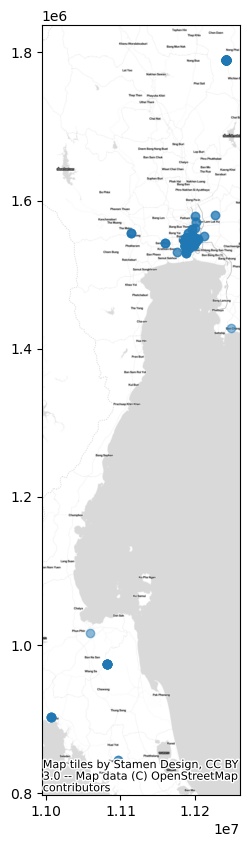

In [28]:
# plot with Thailand map
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))
gdf.to_crs(epsg=3857).plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.show()

In [ ]:
gdf.to_csv("../intermediate/ect_batch_1_gpd.csv")

# Inspect Batch 2

In [ ]:
df = pd.read_parquet("../intermediate/ect_batch_2.parquet")

In [31]:
df[["Lat", "Lng", "Formatted_Address", "PlaceId"]] = df.loc[
    df.index[:10000], "GMap"
].apply(
    lambda x: parse_gmap(x),
)

In [33]:
df.loc[df.index[:10000]].Lat.isna().sum()

234

In [ ]:
gdf = gpd.GeoDataFrame(
    df.loc[df.index[:10000]],
    geometry=gpd.points_from_xy(
        df.loc[df.index[:10000]].Lng, df.loc[df.index[:10000]].Lat
    ),
    crs="EPSG:4326",
)

gdf.to_csv("../intermediate/ect_batch_2_gpd.csv")

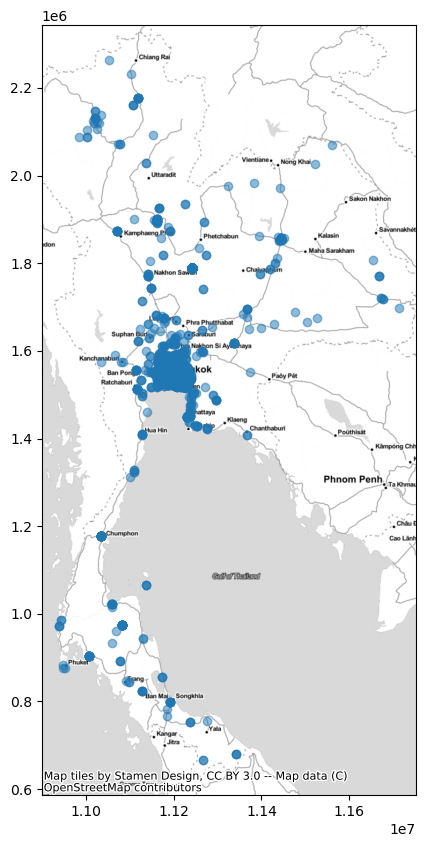

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.to_crs(epsg=3857).plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.show()

# Inspect Batch 3

In [ ]:
df = pd.read_parquet("../intermediate/ect_batch_3.parquet")


df[["Lat", "Lng", "Formatted_Address", "PlaceId"]] = df["GMap"].apply(
    lambda x: parse_gmap(x),
)

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Lng, df.Lat),
    crs="EPSG:4326",
)

gdf.to_csv("../intermediate/ect_batch_3_gpd.csv")

fig, ax = plt.subplots(figsize=(10, 10))
gdf.to_crs(epsg=3857).plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.show()

In [39]:
df.Lat.isna().sum()

2810

In [ ]:
# Save combined GeoDataFrame for spatial validation step
gdf.to_parquet("../intermediate/google_geocoding_raw.parquet")
print(
    f"Saved {len(gdf):,} geocoded units to ../intermediate/google_geocoding_raw.parquet"
)

In [43]:
gdf.head()

,ProvinceId,ProvinceName,DivisionId,DivisionNumber,DistrictId,DistrictName,SubDistrictId,SubDistrictName,UnitId,UnitNumber,UnitName,DisplayUnitName,GMap,Lat,Lng,Formatted_Address,PlaceId,geometry
0,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010101,1,หอประชุม มหาวิทยาลัยศิลปากร ถนนมหาราช,1 - หอประชุม มหาวิทยาลัยศิลปากร ถนนมหาราช,"[{'address_components': [{'long_name': '31', '...",13.752489,100.489988,31 ถนน หน้าพระลาน แขวงพระบรมมหาราชวัง เขตพระนค...,ChIJywjLUgmZ4jARkkNmxCRfTF0,POINT (100.48999 13.75249)
1,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010102,2,โรงเรียนวัดมหาธาตุ ถนนพระจันทร์,2 - โรงเรียนวัดมหาธาตุ ถนนพระจันทร์,"[{'address_components': [{'long_name': '3', 's...",13.755134,100.490892,3 ถนน ท่าพระจันทร์ แขวงพระบรมมหาราชวัง เขตพระน...,ChIJA7PG9AuZ4jARIyvh-TR_wkA,POINT (100.49089 13.75513)
2,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010103,3,ศาลาหน้าอาคารวาสนะประทานวิทยาสิทธิ์ 1 โรงเรียน...,3 - ศาลาหน้าอาคารวาสนะประทานวิทยาสิทธิ์ 1 โรงเ...,"[{'address_components': [{'long_name': '3', 's...",13.745253,100.495574,3 ถนน สนามไชย แขวงพระบรมมหาราชวัง เขตพระนคร กร...,ChIJV_-yxQSZ4jAR2GWdpHhQYVM,POINT (100.49557 13.74525)
3,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010104,4,โรงเรียนวัดพระเชตุพน ถนนมหาราช,4 - โรงเรียนวัดพระเชตุพน ถนนมหาราช,"[{'address_components': [{'long_name': '2', 's...",13.746424,100.492773,2 ถนน สนามไชย แขวงพระบรมมหาราชวัง เขตพระนคร กร...,ChIJgcxFcQWZ4jARLsIR9Qia9H0,POINT (100.49277 13.74642)
4,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010102,วังบูรพาภิรมย์,1001010201,1,ตึกสามัคยาจารย์ โรงเรียนสวนกุหลาบวิทยาลัย ถนนต...,1 - ตึกสามัคยาจารย์ โรงเรียนสวนกุหลาบวิทยาลัย ...,"[{'address_components': [{'long_name': '88', '...",13.742731,100.498414,88 ถ. ตรีเพชร แขวงวังบูรพาภิรมย์ เขตพระนคร กรุ...,ChIJYdJRMMmZ4jARXjDIQMNyq_k,POINT (100.49841 13.74273)


# Inspect The 20k cluster

In [1]:
# find largest dup lat lng
gdf.groupby(["Lat", "Lng"]).size().sort_values(ascending=False).head(10)

NameError: name 'gdf' is not defined